In [37]:
import pandas as pd
import numpy as np

file_path = "Data/out/202403142256.json"

def read_json(file_path):
    return pd.read_json(file_path, lines=True, dtype={"Timestamp": int})

def hex_to_int(n):
    return int(hex(n)[-7:])

def preprocess(df):
    # Convert "timestamp" column to hexadecimal values
    df["Timestamp_hex"] = df["Timestamp"].apply(lambda x: hex(x))
    df["Timestamp"] = df["Timestamp"].apply(hex_to_int)
    
    df_measures = df[df['Type'] == 2][['Timestamp', 'Measure']]
    df_frequencies = df[df['Type'] == 3][['Timestamp', 'Frequency']]
    df_m = pd.merge(df_measures, df_frequencies, on="Timestamp", how="inner")

    df_measures = df_m.drop(columns=['Frequency'])
    df_frequencies = df_m.drop(columns=['Measure'])

    df_measures = df_measures.explode('Measure')
    df_frequencies = df_frequencies.explode('Frequency')

    df_m = df_measures
    df_m['Frequency'] = df_frequencies['Frequency']

    return df_m

df = read_json(file_path)
df_m = preprocess(df)

sample_rate = df_m.shape[0] / 60 # One file is 60 seconds long
sample_rate
print(f"Sample rate: {sample_rate} Hz")

df.head(5)


Sample rate: 772.5 Hz


,Checksum,Type,Encrypted,Reserved,Timestamp,Start,End,RBW,Scale,Trigger,Duration,Offset,Points,Slot,Band,Trace,Measure,Frequency,Timestamp_hex
0,73,2,False,0,6020140,2.190000e+09,2.700000e+09,300000,-5.000000e+01,15,375.0,0,450,0,40,0.0,"[5.0882034, 1.0894165, 6.090622, 4.091835, 4.0...",NaN,0x2403142256020140
1,141,3,False,0,6020761,NaN,NaN,300000,7.147555e-15,15,NaN,0,450,0,0,NaN,NaN,"[2190000000, 2191135857, 2192271715, 219340757...",0x2403142256020761
2,62,2,False,0,6020761,2.190000e+09,2.700000e+09,300000,-5.000000e+01,15,421.0,0,450,0,40,0.0,"[4.191864, 4.1932983, 6.1947403, 4.6961746, 2....",NaN,0x2403142256020761
3,50,3,False,0,6030355,NaN,NaN,300000,7.147555e-15,15,NaN,0,450,0,0,NaN,NaN,"[2190000000, 2191135857, 2192271715, 219340757...",0x2403142256030355
4,219,2,False,0,6030355,2.190000e+09,2.700000e+09,300000,-5.000000e+01,15,395.0,0,450,0,40,0.0,"[5.8179092, 4.320015, 3.3221207, 4.8242264, 3....",NaN,0x2403142256030355


In [7]:
print("Total rows:", df.shape[0], "Types:", np.unique(df['Type']).shape[0])
diffs = df[df['Type'] == 2]['Timestamp'].diff().dropna()

# Find the index of the row with the largest difference
max_difference_index = diffs.idxmax()
df[max_difference_index-3:max_difference_index+3]

print(np.unique(diffs, return_counts=True))
print(np.unique(df['Timestamp']).shape[0])

Total rows: 127 Types: 2
(array([ 390.,  391.,  394.,  395.,  398.,  399.,  403.,  406.,  414.,
       9391., 9394., 9395., 9398., 9399., 9403., 9406.]), array([ 2,  4, 12,  8,  5,  2,  2,  2,  1,  3,  7,  8,  2,  3,  1,  1]))
64


In [49]:
df_m.head(5)

,Timestamp,Measure,Frequency
0,1000578,-0.795776,700000000
0,1000578,6.164291,700579065
0,1000578,3.655617,701158129
0,1000578,4.146935,701737194
0,1000578,7.638252,702316258


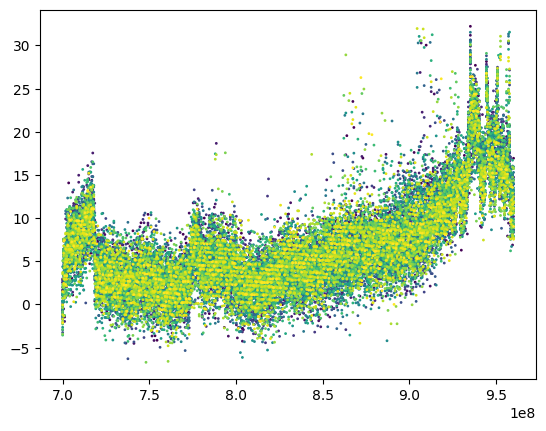

In [50]:
import matplotlib.pyplot as plt

plt.scatter(df_m['Frequency'], df_m['Measure'], c=df_m['Timestamp'], s=1)
plt.show()


In [31]:
import os

folder_path = 'Data/out'

files = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f)) & f.endswith('.json')]

for i, file in enumerate(files, start=1):
    df = read_json(os.path.join(folder_path, file))
    df_m = preprocess(df)
    plt.scatter(df_m['Frequency'], df_m['Measure'], c=df_m['Timestamp'], s=1)
    plt.savefig(f'Plots/{file}.png')
    plt.clf()


KeyError: "['Frequency'] not in index"

<Figure size 640x480 with 0 Axes>

/var/folders/yn/16crnc792zg2yr78zf0qg0j40000gq/T/ipykernel_78064/3906823402.py:10: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  sc = ax.scatter(df_m['Frequency'].iloc[0], y = df_m['Measure'].iloc[0], cmap='viridis', alpha=1, s=2)


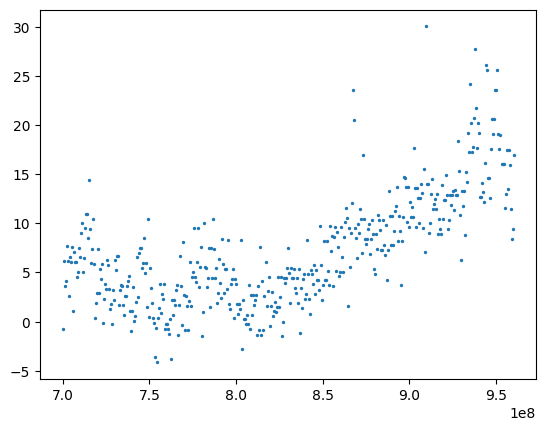

In [46]:
import matplotlib.animation as animation

df = read_json(file_path)

df_measures = df[df['Type'] == 2][['Timestamp', 'Measure']]
df_frequencies = df[df['Type'] == 3][['Timestamp', 'Frequency']]
df_m = pd.merge(df_measures, df_frequencies, on="Timestamp", how="inner")

fig, ax = plt.subplots()
sc = ax.scatter(df_m['Frequency'].iloc[0], y = df_m['Measure'].iloc[0], cmap='viridis', alpha=1, s=2)

def update(frame):
    # Update data for each frame
    x = df_m['Frequency'].iloc[frame]
    y = df_m['Measure'].iloc[frame]
    # colors = np.random.rand(50)
    # sizes = 100 * np.random.rand(50)

    # Update scatter plot data
    sc.set_offsets(np.c_[x, y])
    # sc.set_array(colors)
    # sc.set_sizes(sizes)

# Create animation
ani = animation.FuncAnimation(fig, update, frames=df_m.shape[0], interval=5000)

# Show the plot
plt.show()

# Save animation
ani.save('animation.gif', writer='imagemagick', fps=30)

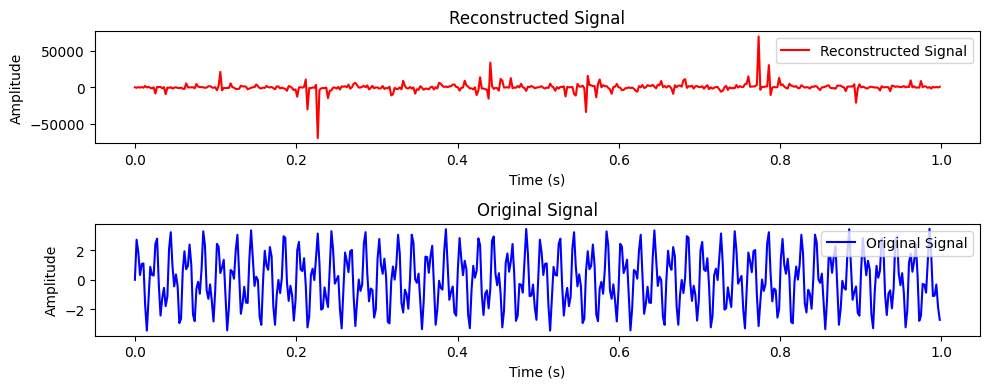

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# Function to reconstruct a signal from frequencies and amplitudes
def reconstruct_signal(frequencies, amplitudes, duration=1, sampling_rate=1000):
    t = np.linspace(0, duration, int(duration * sampling_rate), endpoint=False)
    signal = np.zeros_like(t)

    for freq, amp in zip(frequencies, amplitudes):
        signal += amp * np.sin(2 * np.pi * freq * t)

    return t, signal

# Reconstruct the signal
duration = 1
time, reconstructed_signal = reconstruct_signal(df_m['Frequency'], df_m['Measure'], duration, sample_rate)

# Plot the original and reconstructed signals
plt.figure(figsize=(10, 4))
plt.subplot(2, 1, 1)
plt.plot(time, reconstructed_signal, label='Reconstructed Signal', color='red')
plt.title('Reconstructed Signal')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend()

# Plot the original signal for comparison
original_signal = 2 * np.sin(2 * np.pi * 50 * time) + 1.5 * np.sin(2 * np.pi * 120 * time)
plt.subplot(2, 1, 2)
plt.plot(time, original_signal, label='Original Signal', color='blue')
plt.title('Original Signal')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend()

plt.tight_layout()
plt.show()

In [23]:
from scipy.signal import welch
from scipy.fftpack import fft

# Compute PSD using Welch method
frequencies, psd = welch(df_m['Frequency'], sample_rate, nperseg=256)

# # Alternatively, you can compute PSD using FFT
# frequencies = np.fft.fftfreq(len(reconstructed_signal), 1/sample_rate)
# psd = np.abs(fft(reconstructed_signal))**2 / len(reconstructed_signal)

# Plot the original signal
plt.figure(figsize=(10, 6))
plt.subplot(2, 1, 1)
plt.plot(time, reconstructed_signal)
plt.title('Original Signal')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')

# Plot the Power Spectral Density
plt.subplot(2, 1, 2)
plt.semilogy(frequencies, psd)
plt.title('Power Spectral Density (PSD)')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power/Frequency (dB/Hz)')

plt.tight_layout()
plt.show()

TypeError: '<' not supported between instances of 'complex' and 'complex'

(265, 3)


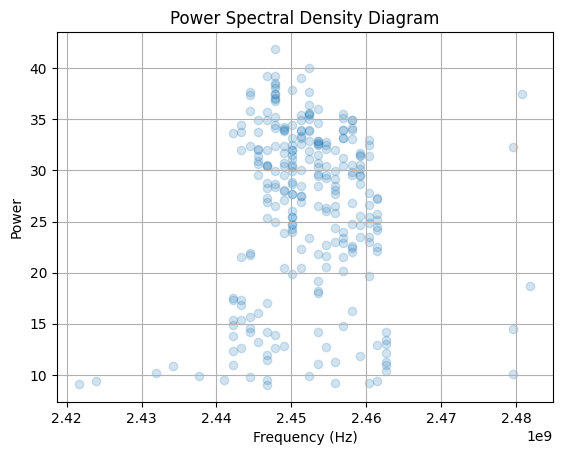

In [53]:
# Plotting the data
df_m_f = df_m[df_m['Measure'] > 9]
df_m_f = df_m_f[(df_m_f['Frequency'] > 2.4*1e9) & (df_m_f['Frequency'] < 2.5*1e9)]
print(df_m_f.shape)

plt.scatter(df_m_f['Frequency'], df_m_f['Measure'], marker='o', alpha=0.2)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power')
plt.title('Power Spectral Density Diagram')
plt.grid(True)
plt.show()

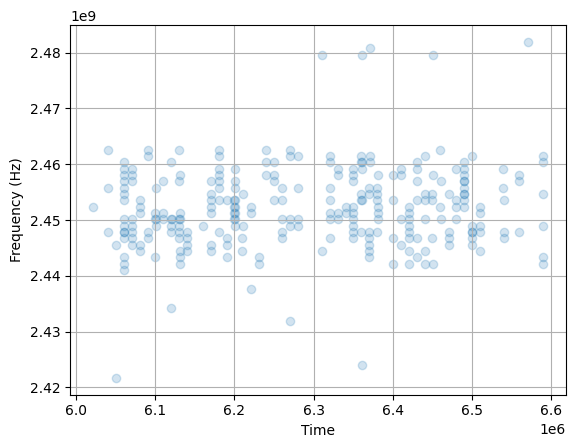

In [54]:
plt.scatter(df_m_f['Timestamp'], df_m_f['Frequency'], marker='o', alpha=0.2)
plt.ylabel('Frequency (Hz)')
plt.xlabel('Time')
plt.grid(True)
plt.show()